In [139]:
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate, GroupKFold #, LeaveOneGroupOut
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from tqdm import tqdm

from functools import partial
from pathlib import Path
import random

In [2]:
PROCESSED_DATA_DIR_PATH = Path('.') / '..' / 'data' / 'processed_data'

<a id='baselines'></a>

# BASELINE MODELS

Average the entire year of data for each district. Same model is used for all states.

This yields only ~173 rows, so we use k-fold Cross Validation to measure model performance. _Note that the folds are constructed to ensure that all data from a given state is in either the test or train split._

### Test Score Baselines

Each baseline trains 4 Ridge regression models ($\alpha = 0.5$), one for each comination of 4th & 8th grade, math & reading test scores, using 5- and 10-fold cross-validation. We select the better performing of the two cross-validations (on the training set) and select the corresponding test results.

- ___Baseline 1___: Uses engagement data only. ([Model](#baseline1_model) / [Results](#baseline1_results))
- ___Baseline 1a___: Uses average engagement data only, split into product types. Performed comparably to Baseline 1. ([Model](#baseline1a_model) / [Results](#baseline1a_results))
- ___Baseline 1b___: Uses median engagement data only, split into product types. Outperformed by Baselines 1 and 1a. ([Model](#baseline1b_model) / [Results](#baseline1b_results))
- ___Baseline 2___: Uses locale type only. Outperformed Baseline 1. ([Model](#baseline2_model) / [Results](#baseline2_results))
- ___Baseline 3___: Uses broadband data only. Outperformed by Baseline 1. ([Model](#baseline3_model) / [Results](#baseline3_results))

### Other Test Score Models

- ___Decision Tree 1___: Uses average engagement data (split into product types) along with locale type and broadband data. Worse than baseline models. ([Model](#tree1_model) / [Results](#tree1_results))


In [10]:
INPUT_FEATURES = ['engagement;pct_access',
                  'engagement;engagement_index',
                  'districts;locale',
                  'districts;state',
                  'broadband;wired_over_25',
                  'broadband;avg_mbps', 
                  'broadband;frac_access', 
                  'broadband;lowest_price'
                 ]

TARGET_FEATURES = ['testscores;math_4_2022',
                   'testscores;math_8_2022',
                   'testscores;reading_4_2022',
                   'testscores;reading_8_2022',
                  ]

In [187]:
dataset = None

for state_data_path in tqdm(PROCESSED_DATA_DIR_PATH.glob('*.gz'), total=23):
    df = pd.read_pickle(state_data_path)

    df_temp = df.groupby(['time', 'district_id']).first()

    columns_to_average = ['engagement;pct_access', 'engagement;engagement_index']
    columns_to_reset = ['products;Sector(s)', 'products;Primary Essential Function']

    df_temp[columns_to_average] = df.groupby(['time', 'district_id']).mean()[columns_to_average]
    df_temp[columns_to_reset] = None

    df = df_temp
    del df_temp
    
    for district_id in df.index.levels[1]:
        df_temp = df.loc[(slice(None), district_id), :]
        row = df_temp.iloc[0][INPUT_FEATURES + TARGET_FEATURES]
        row.loc[columns_to_average] = df_temp[columns_to_average].mean()
        row['n_days'] = len(df_temp)
        if dataset is None:
            dataset = pd.DataFrame(row).T.reset_index(level=0)
        else:
            dataset = pd.concat([dataset, pd.DataFrame(row).T.reset_index(level=0)])
            
for l in ['City', 'Suburb', 'Rural', 'Town']:
    dataset['districts;locale_{}'.format(l.lower())] = dataset['districts;locale'].apply(lambda x: int(x == l))
    
#dataset = dataset.drop(['level_0', 'districts;locale'], axis=1)
dataset = dataset.drop(['level_0'], axis=1)


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:20<00:00,  1.12it/s]


In [235]:
df = pd.read_csv(PROCESSED_DATA_DIR_PATH / 'LearnPlatform_engage_district_wide.csv')
df = df.drop(['state'], axis=1)
df = df.set_index(['district_id'])
df = df.rename(lambda col_name: 'engagement;{}'.format(col_name), axis=1)
dataset = dataset.join(df)

In [236]:
dataset

,engagement;pct_access,engagement;engagement_index,districts;locale,districts;state,broadband;wired_over_25,broadband;avg_mbps,broadband;frac_access,broadband;lowest_price,testscores;math_4_2022,testscores;math_8_2022,...,engagement;avg_CM,engagement;avg_LC,engagement;avg_LC_CM_SDO,engagement;avg_Missing,engagement;avg_SDO,engagement;med_CM,engagement;med_LC,engagement;med_LC_CM_SDO,engagement;med_Missing,engagement;med_SDO
9007,1.964617,567.28607,City,Arizona,0.82173,24.11994,0.23648,15.5471,230,267,...,506.734803,783.798566,295.944008,374.427829,2338.686585,23.710,23.40,25.860,7.54,37.720
1570,0.518174,84.132317,Suburb,California,1.23725,23.10062,0.2465,9.0179,235.0,269.0,...,144.576851,122.771451,89.129722,44.883813,692.672180,9.160,9.66,11.660,2.00,33.585
2074,0.109114,34.732466,Suburb,California,1.23725,23.10062,0.2465,9.0179,235.0,269.0,...,48.042894,98.262102,122.338390,20.543905,27.147659,1.670,2.28,2.470,0.45,1.800
2106,0.207801,66.760789,Suburb,California,1.23725,23.10062,0.2465,9.0179,235.0,269.0,...,54.788636,111.622742,91.751692,29.122240,186.552288,6.780,3.79,9.625,1.66,3.150
2172,0.81368,282.176262,City,California,1.36228,23.72792,0.2486,8.72419,227.0,274.0,...,1341.901874,441.640026,434.938842,71.329144,2197.199267,7.755,10.40,19.130,1.46,9.005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5510,0.141797,24.367871,City,Washington,1.05923,21.19728,0.24797,14.27715,238,277,...,63.124194,59.864299,75.974488,14.229446,384.795328,0.740,1.76,1.150,0.19,2.170
7457,0.312187,73.94003,City,Washington,1.05923,21.19728,0.24797,14.27715,238,277,...,163.828281,126.603409,116.242942,28.350720,636.227558,1.130,2.88,3.580,0.35,3.710
5987,0.730825,181.37924,Suburb,Wisconsin,1.19913,19.45233,0.24867,10.4515,250,286,...,283.410048,258.735874,473.230489,85.381382,1325.292925,7.370,6.88,21.180,1.84,14.800
7752,0.560572,117.393178,Suburb,Wisconsin,1.19913,19.45233,0.24867,10.4515,250,286,...,287.388689,266.588261,496.962987,91.637230,145.666562,3.850,7.03,10.745,1.52,6.810


In [237]:
# ## ensure cross validation respects states (i.e., all data from a given state is in either the
# ## test or train split - so if a "California Suburb" district is in the training split, all 
# ## "California Suburb" (and city/town/rural) districts would also be in the training split)
# k_fold_groups = pd.factorize(dataset['districts;state'])[0]

## ensure cross validation respects state/locale combinations (i.e., all data from a given state 
## and locale type is in either the test or train split - so "California Suburb" can be in the
## training split and "California City" can be in the test split, but all "California Suburb"
## districts would be in the training split)
k_fold_groups = pd.factorize(list(zip(list(dataset['districts;state']), list(dataset['districts;locale']))))[0]

In [243]:
def run_experiment(dataset, input_features_list, model_type, n_splits=5):
    results = []
    for target in ['testscores;math_4_2022', 
                   'testscores;math_8_2022', 
                   'testscores;reading_4_2022', 
                   'testscores;reading_8_2022']:

        X = np.array(dataset[input_features_list]).astype(float)
        Y = np.array(dataset[[target]]).astype(float).squeeze(-1)

        X = X[~np.isnan(Y)]
        groups = k_fold_groups[~np.isnan(Y)]
        Y = Y[~np.isnan(Y)]

        model = make_pipeline(preprocessing.StandardScaler(), 
                              model_type)

        kf_splits = GroupKFold(n_splits=n_splits)
        results_dict = cross_validate(model, X, Y, 
                                      cv=kf_splits, 
                                      groups=groups,
                                      scoring=['r2', 'neg_root_mean_squared_error'],
                                      return_train_score=True,
                                      return_estimator=True)
        results.append((results_dict, target, scoring_metrics_list, (kf_splits, groups), X, Y))
        
    return results


def print_results(results_dict, target_feature, scoring_metrics_list, *args,
                  splits=['train']):
    d = {}
    for scoring_metric in scoring_metrics_list:
        for split in splits:
            m = '{}_{}'.format(split, scoring_metric)
            r = round(np.mean(results_dict[m]), 4)
            if scoring_metric.startswith('neg'):
                r = -r
                m = '{}_{}'.format(split, scoring_metric[4:])

            d[m] = {target_feature: r}
    display(pd.DataFrame(d).T)
        
        
def plot_residuals(results_dict):
    for i, target in enumerate(['testscores;math_4_2022', 
                                'testscores;math_8_2022', 
                                'testscores;reading_4_2022', 
                                'testscores;reading_8_2022']):
        predictions = []
        ground_truth = []
        
        X = results_dict[i][-2]
        Y = results_dict[i][-1]

        for (_, test_index), model in zip(results_dict[i][-3][0].split(X, groups=results_dict[i][-3][1]), 
                                          results_dict[i][0]['estimator']):
            predictions += list(model.predict(X[test_index]))
            ground_truth += list(Y[test_index])

        sort_indices = np.argsort(ground_truth)
        ground_truth = np.array(ground_truth)[sort_indices]
        predictions = np.array(predictions)[sort_indices]

        fig, ax = plt.subplots(figsize=(6, 3))

        ax.scatter(range(len(ground_truth)), ground_truth, marker='.', label='Ground Truth')
        ax.scatter(range(len(predictions)), predictions, marker='.', label='Model Prediction')
        ax.set_title(target)
        ax.legend();
        display(fig)
        plt.close();
        

<a id='baseline1_model'></a>

## Baseline 1: Predict Math and Reading Scores from Engagement Data Only

[(Back to top)](#baselines)

In [244]:
FEATURES = ['engagement;pct_access', 
            'engagement;engagement_index']

five_fold_results = run_experiment(dataset, 
                                   FEATURES,
                                   Ridge(alpha=0.5), 
                                   n_splits=5)

ten_fold_results = run_experiment(dataset, 
                                  FEATURES,
                                  Ridge(alpha=0.5), 
                                  n_splits=10)


### 5-Fold Training Results

In [245]:
for results in five_fold_results:
    print_results(*results)

,testscores;math_4_2022
train_r2,0.0181
train_root_mean_squared_error,7.1111


,testscores;math_8_2022
train_r2,0.0303
train_root_mean_squared_error,6.8874


,testscores;reading_4_2022
train_r2,0.0144
train_root_mean_squared_error,7.4845


,testscores;reading_8_2022
train_r2,0.0218
train_root_mean_squared_error,5.8321


### 10-Fold Training Results

In [246]:
for results in ten_fold_results:
    print_results(*results)

,testscores;math_4_2022
train_r2,0.0235
train_root_mean_squared_error,7.1025


,testscores;math_8_2022
train_r2,0.0246
train_root_mean_squared_error,6.9113


,testscores;reading_4_2022
train_r2,0.0182
train_root_mean_squared_error,7.4818


,testscores;reading_8_2022
train_r2,0.0158
train_root_mean_squared_error,5.8532


Five-fold outperformed ten-fold (though neither did very well). We check the test performance:

<a id='baseline1_results'></a>

### Baseline 1 Testing Results

[(Back to top)](#baselines)

In [247]:
for results in five_fold_results:
    print_results(*results, splits=['test'])

,testscores;math_4_2022
test_r2,-0.2284
test_root_mean_squared_error,7.3217


,testscores;math_8_2022
test_r2,-0.1361
test_root_mean_squared_error,6.8881


,testscores;reading_4_2022
test_r2,-0.2603
test_root_mean_squared_error,7.6656


,testscores;reading_8_2022
test_r2,-0.2341
test_root_mean_squared_error,5.9078


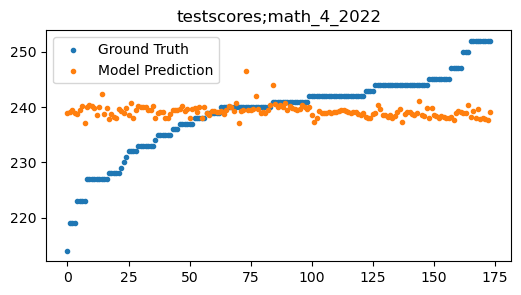

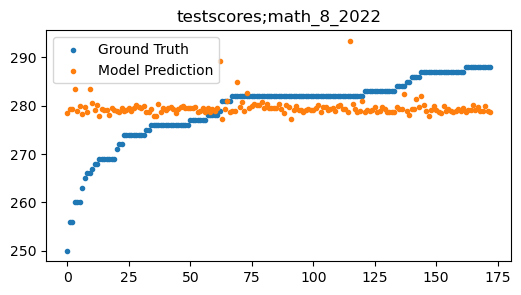

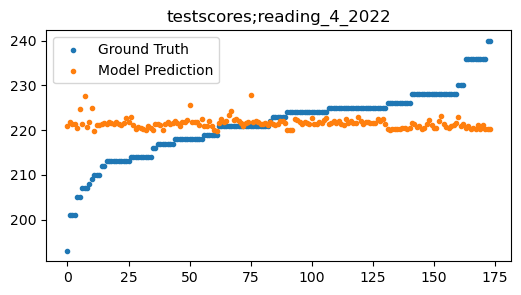

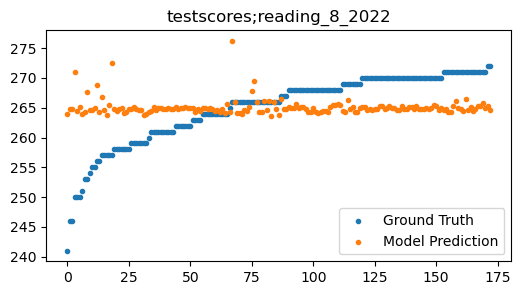

In [248]:
plot_residuals(five_fold_results)

<a id='baseline1a_model'></a>

## Baseline 1a: Predict Math and Reading Scores from Engagement Data Only

[(Back to top)](#baselines)

In [253]:
FEATURES = ['engagement;avg_SDO',
            'engagement;avg_CM',
            'engagement;avg_LC', 
            'engagement;avg_LC_CM_SDO', 
            'engagement;avg_Missing']

five_fold_results = run_experiment(dataset, 
                                   FEATURES,
                                   Ridge(alpha=0.5), 
                                   n_splits=5)


### 5-Fold Training Results

In [254]:
for results in five_fold_results:
    print_results(*results)

,testscores;math_4_2022
train_r2,0.0795
train_root_mean_squared_error,6.8851


,testscores;math_8_2022
train_r2,0.1024
train_root_mean_squared_error,6.6238


,testscores;reading_4_2022
train_r2,0.0927
train_root_mean_squared_error,7.1840


,testscores;reading_8_2022
train_r2,0.1340
train_root_mean_squared_error,5.4874


<a id='baseline1a_results'></a>

### Baseline 1a Testing Results

[(Back to top)](#baselines)

In [255]:
for results in five_fold_results:
    print_results(*results, splits=['test'])

,testscores;math_4_2022
test_r2,-0.2966
test_root_mean_squared_error,7.5248


,testscores;math_8_2022
test_r2,-0.1140
test_root_mean_squared_error,6.8426


,testscores;reading_4_2022
test_r2,-0.2650
test_root_mean_squared_error,7.7135


,testscores;reading_8_2022
test_r2,-0.0927
test_root_mean_squared_error,5.6728


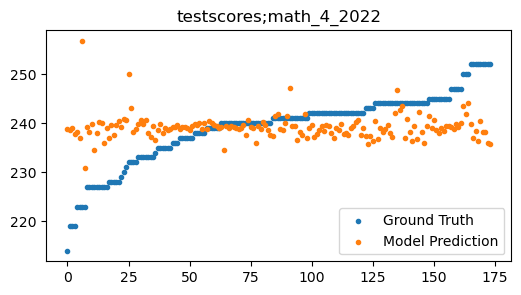

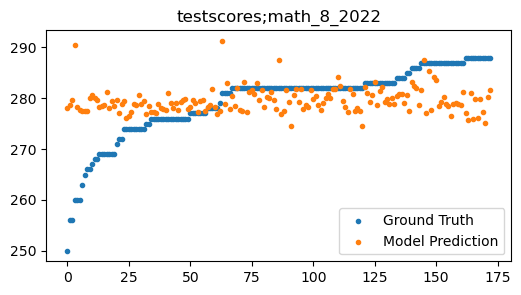

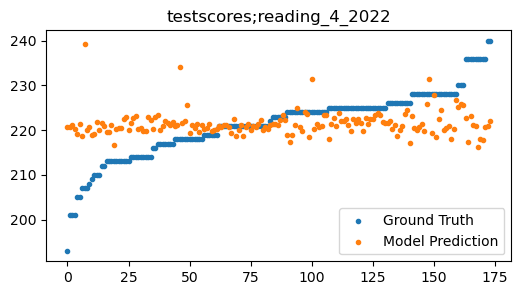

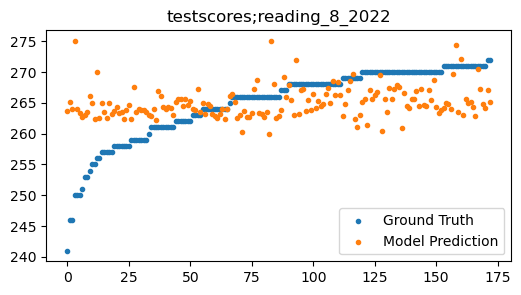

In [256]:
plot_residuals(five_fold_results)

<a id='baseline1b_model'></a>

## Baseline 1b: Predict Math and Reading Scores from Engagement Data Only

[(Back to top)](#baselines)

In [257]:
FEATURES = ['engagement;med_SDO',
            'engagement;med_CM',
            'engagement;med_LC', 
            'engagement;med_LC_CM_SDO', 
            'engagement;med_Missing']

five_fold_results = run_experiment(dataset, 
                                   FEATURES,
                                   Ridge(alpha=0.5), 
                                   n_splits=5)


### 5-Fold Training Results

In [258]:
for results in five_fold_results:
    print_results(*results)

,testscores;math_4_2022
train_r2,0.0545
train_root_mean_squared_error,6.9762


,testscores;math_8_2022
train_r2,0.0729
train_root_mean_squared_error,6.7243


,testscores;reading_4_2022
train_r2,0.0547
train_root_mean_squared_error,7.3279


,testscores;reading_8_2022
train_r2,0.0628
train_root_mean_squared_error,5.7033


<a id='baseline1b_results'></a>

### Baseline 1b Testing Results

[(Back to top)](#baselines)

In [259]:
for results in five_fold_results:
    print_results(*results, splits=['test'])

,testscores;math_4_2022
test_r2,-0.5956
test_root_mean_squared_error,7.9085


,testscores;math_8_2022
test_r2,-1.3168
test_root_mean_squared_error,8.5349


,testscores;reading_4_2022
test_r2,-0.5970
test_root_mean_squared_error,8.2482


,testscores;reading_8_2022
test_r2,-1.7108
test_root_mean_squared_error,7.1956


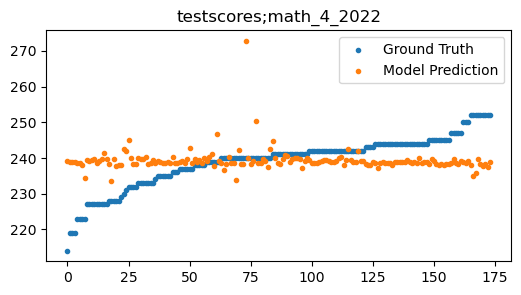

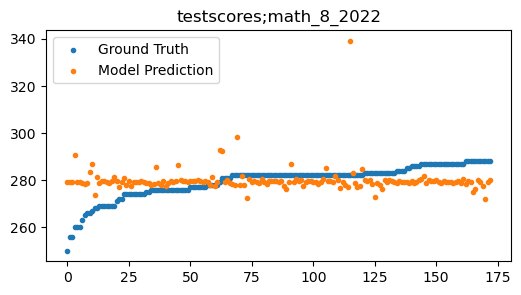

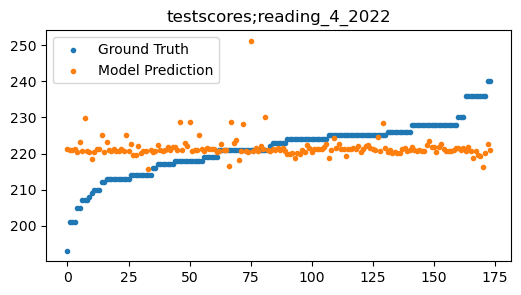

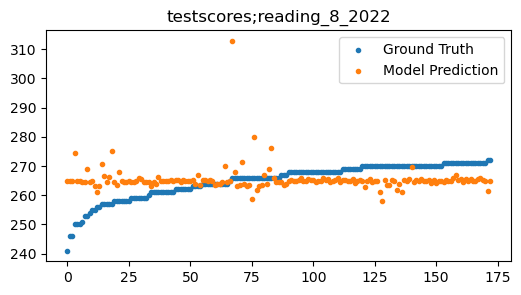

In [260]:
plot_residuals(five_fold_results)

<a id='baseline2_model'></a>

## Baseline 2: Predict Math and Reading Scores from Locale Type Only

[(Back to top)](#baselines)

In [264]:
FEATURES = ['districts;locale_city', 
            'districts;locale_suburb', 
            'districts;locale_town',
            'districts;locale_rural']

five_fold_results = run_experiment(dataset, 
                                   FEATURES,
                                   Ridge(alpha=0.5), 
                                   n_splits=5)

ten_fold_results = run_experiment(dataset, 
                                  FEATURES,
                                  Ridge(alpha=0.5), 
                                  n_splits=10)
    

### 5-Fold Training Results

In [265]:
for results in five_fold_results:
    print_results(*results)

,testscores;math_4_2022
train_r2,0.4577
train_root_mean_squared_error,5.2863


,testscores;math_8_2022
train_r2,0.5182
train_root_mean_squared_error,4.8438


,testscores;reading_4_2022
train_r2,0.3916
train_root_mean_squared_error,5.8793


,testscores;reading_8_2022
train_r2,0.5210
train_root_mean_squared_error,4.0543


### 10-Fold Training Results

In [211]:
for results in ten_fold_results:
    print_results(*results)

,testscores;math_4_2022
train_r2,0.4626
train_root_mean_squared_error,5.2587


,testscores;math_8_2022
train_r2,0.5146
train_root_mean_squared_error,4.8757


,testscores;reading_4_2022
train_r2,0.3845
train_root_mean_squared_error,5.9227


,testscores;reading_8_2022
train_r2,0.5093
train_root_mean_squared_error,4.1306


Five-fold still outperforms ten-fold _(also note that performance is substantially better than using the engagement data)_. We check the test performance:

<a id='baseline2_results'></a>

### Baseline 2 Testing Results

[(Back to top)](#baselines)

In [212]:
for results in five_fold_results:
    print_results(*results, splits=['test'])

,testscores;math_4_2022
test_r2,0.3088
test_root_mean_squared_error,5.4196


,testscores;math_8_2022
test_r2,0.1333
test_root_mean_squared_error,5.3408


,testscores;reading_4_2022
test_r2,-0.0468
test_root_mean_squared_error,6.7107


,testscores;reading_8_2022
test_r2,-0.3625
test_root_mean_squared_error,5.3745


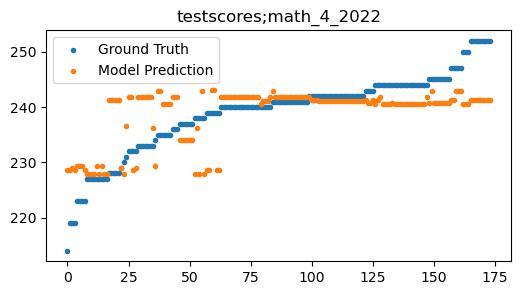

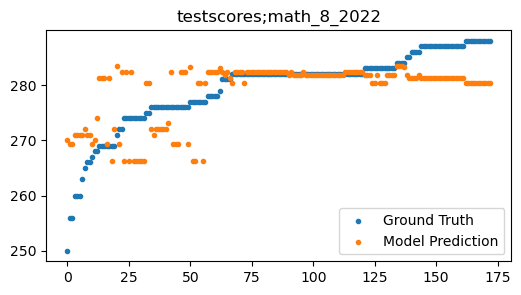

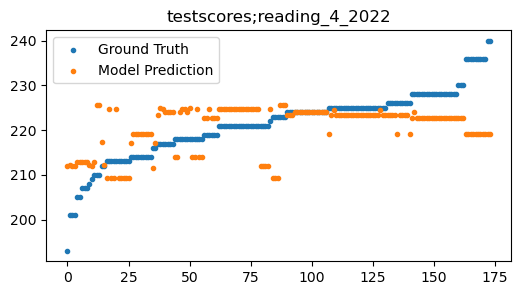

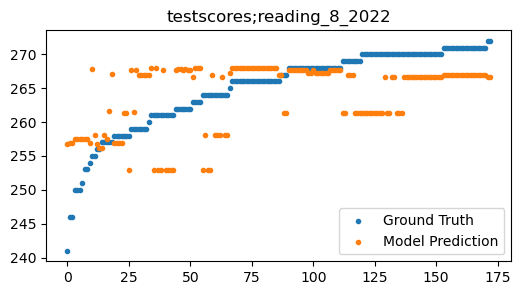

In [213]:
plot_residuals(five_fold_results)

<a id='baseline3_model'></a>

## Baseline 3: Predict Math and Reading Scores from Internet Access Data Only

[(Back to top)](#baselines)

In [266]:
FEATURES = ['broadband;wired_over_25',
            'broadband;avg_mbps', 
            'broadband;frac_access', 
            'broadband;lowest_price']

five_fold_results = run_experiment(dataset, 
                                   FEATURES,
                                   Ridge(alpha=0.5), 
                                   n_splits=5)

ten_fold_results = run_experiment(dataset, 
                                  FEATURES,
                                  Ridge(alpha=0.5), 
                                  n_splits=10)


### 5-Fold Training Results

In [267]:
for results in five_fold_results:
    print_results(*results)

,testscores;math_4_2022
train_r2,0.0899
train_root_mean_squared_error,6.8460


,testscores;math_8_2022
train_r2,0.1389
train_root_mean_squared_error,6.4809


,testscores;reading_4_2022
train_r2,0.1846
train_root_mean_squared_error,6.8066


,testscores;reading_8_2022
train_r2,0.1983
train_root_mean_squared_error,5.2694


### 10-Fold Training Results

In [216]:
for results in ten_fold_results:
    print_results(*results)

,testscores;math_4_2022
train_r2,0.0923
train_root_mean_squared_error,6.8436


,testscores;math_8_2022
train_r2,0.1397
train_root_mean_squared_error,6.4911


,testscores;reading_4_2022
train_r2,0.1817
train_root_mean_squared_error,6.8255


,testscores;reading_8_2022
train_r2,0.2019
train_root_mean_squared_error,5.2705


<a id='baseline3_results'></a>

### Baseline 3 Testing Results

[(Back to top)](#baselines)

In [217]:
for results in five_fold_results:
    print_results(*results, splits=['test'])

,testscores;math_4_2022
test_r2,-0.2706
test_root_mean_squared_error,7.4867


,testscores;math_8_2022
test_r2,-0.1495
test_root_mean_squared_error,6.8742


,testscores;reading_4_2022
test_r2,-0.1406
test_root_mean_squared_error,7.3588


,testscores;reading_8_2022
test_r2,-0.2250
test_root_mean_squared_error,5.6667


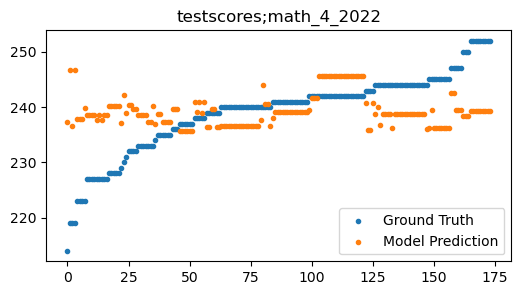

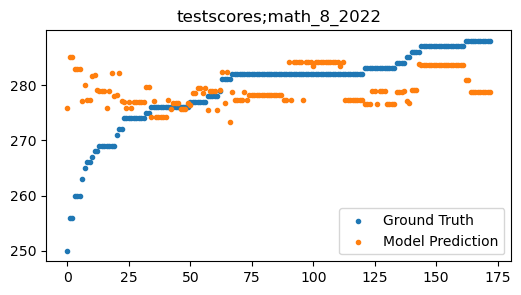

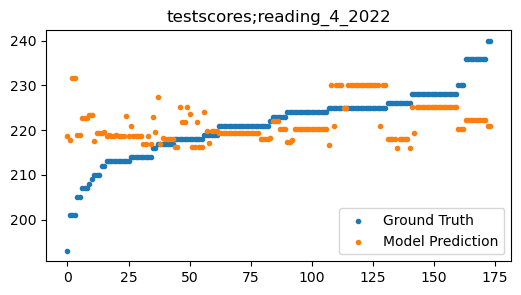

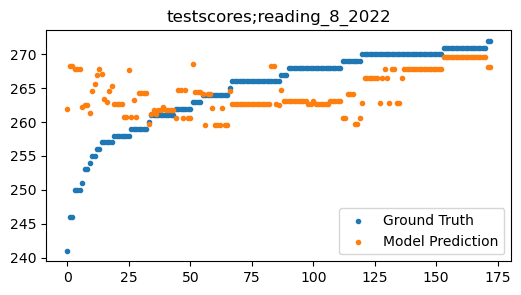

In [218]:
plot_residuals(five_fold_results)

<a id='tree1_model'></a>

## Decision Tree 1: Predict Math and Reading Scores from Engagement, Locale, and Broadband Data

[(Back to top)](#baselines)

In [293]:
FEATURES = ['engagement;avg_SDO',
            'engagement;avg_CM',
            'engagement;avg_LC', 
            'engagement;avg_LC_CM_SDO', 
            'engagement;avg_Missing',
            'districts;locale_city', 
            'districts;locale_suburb', 
            'districts;locale_town',
            'districts;locale_rural',
            'broadband;wired_over_25',
            'broadband;avg_mbps', 
            'broadband;frac_access', 
            'broadband;lowest_price']

five_fold_results = run_experiment(dataset, 
                                   FEATURES,
                                   DecisionTreeRegressor(), 
                                   n_splits=5)


<a id='tree1_results'></a>

### Decision Tree 1 Testing Results

[(Back to top)](#baselines)

In [294]:
for results in five_fold_results:
    print_results(*results, splits=['test'])

,testscores;math_4_2022
test_r2,-1.0852
test_root_mean_squared_error,9.5523


,testscores;math_8_2022
test_r2,-1.5187
test_root_mean_squared_error,8.6059


,testscores;reading_4_2022
test_r2,-1.6205
test_root_mean_squared_error,10.7540


,testscores;reading_8_2022
test_r2,-1.4444
test_root_mean_squared_error,7.2285


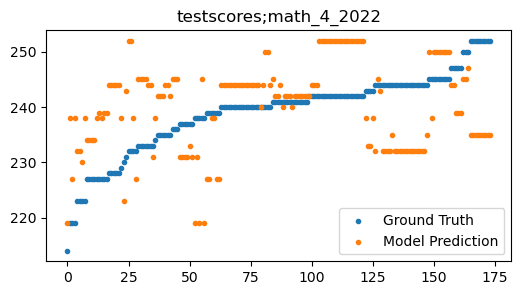

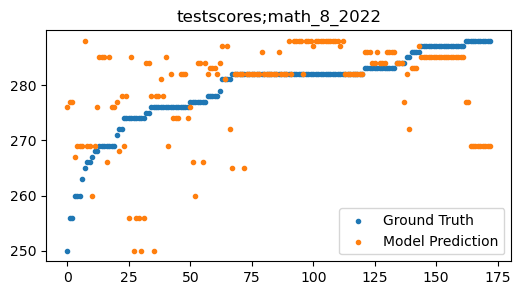

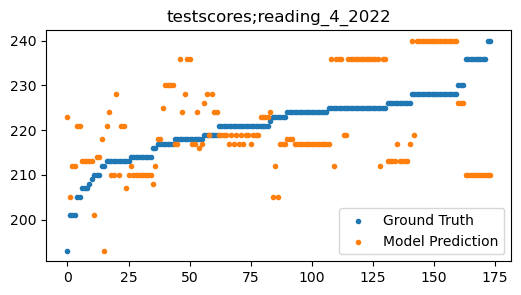

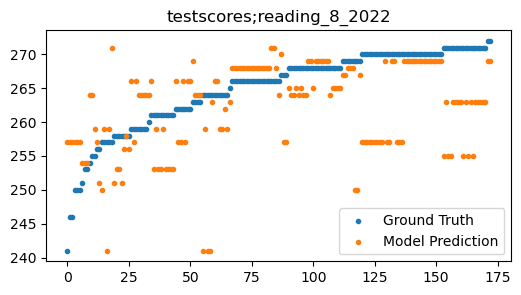

In [295]:
plot_residuals(five_fold_results)

In [296]:
from sklearn.tree import plot_tree

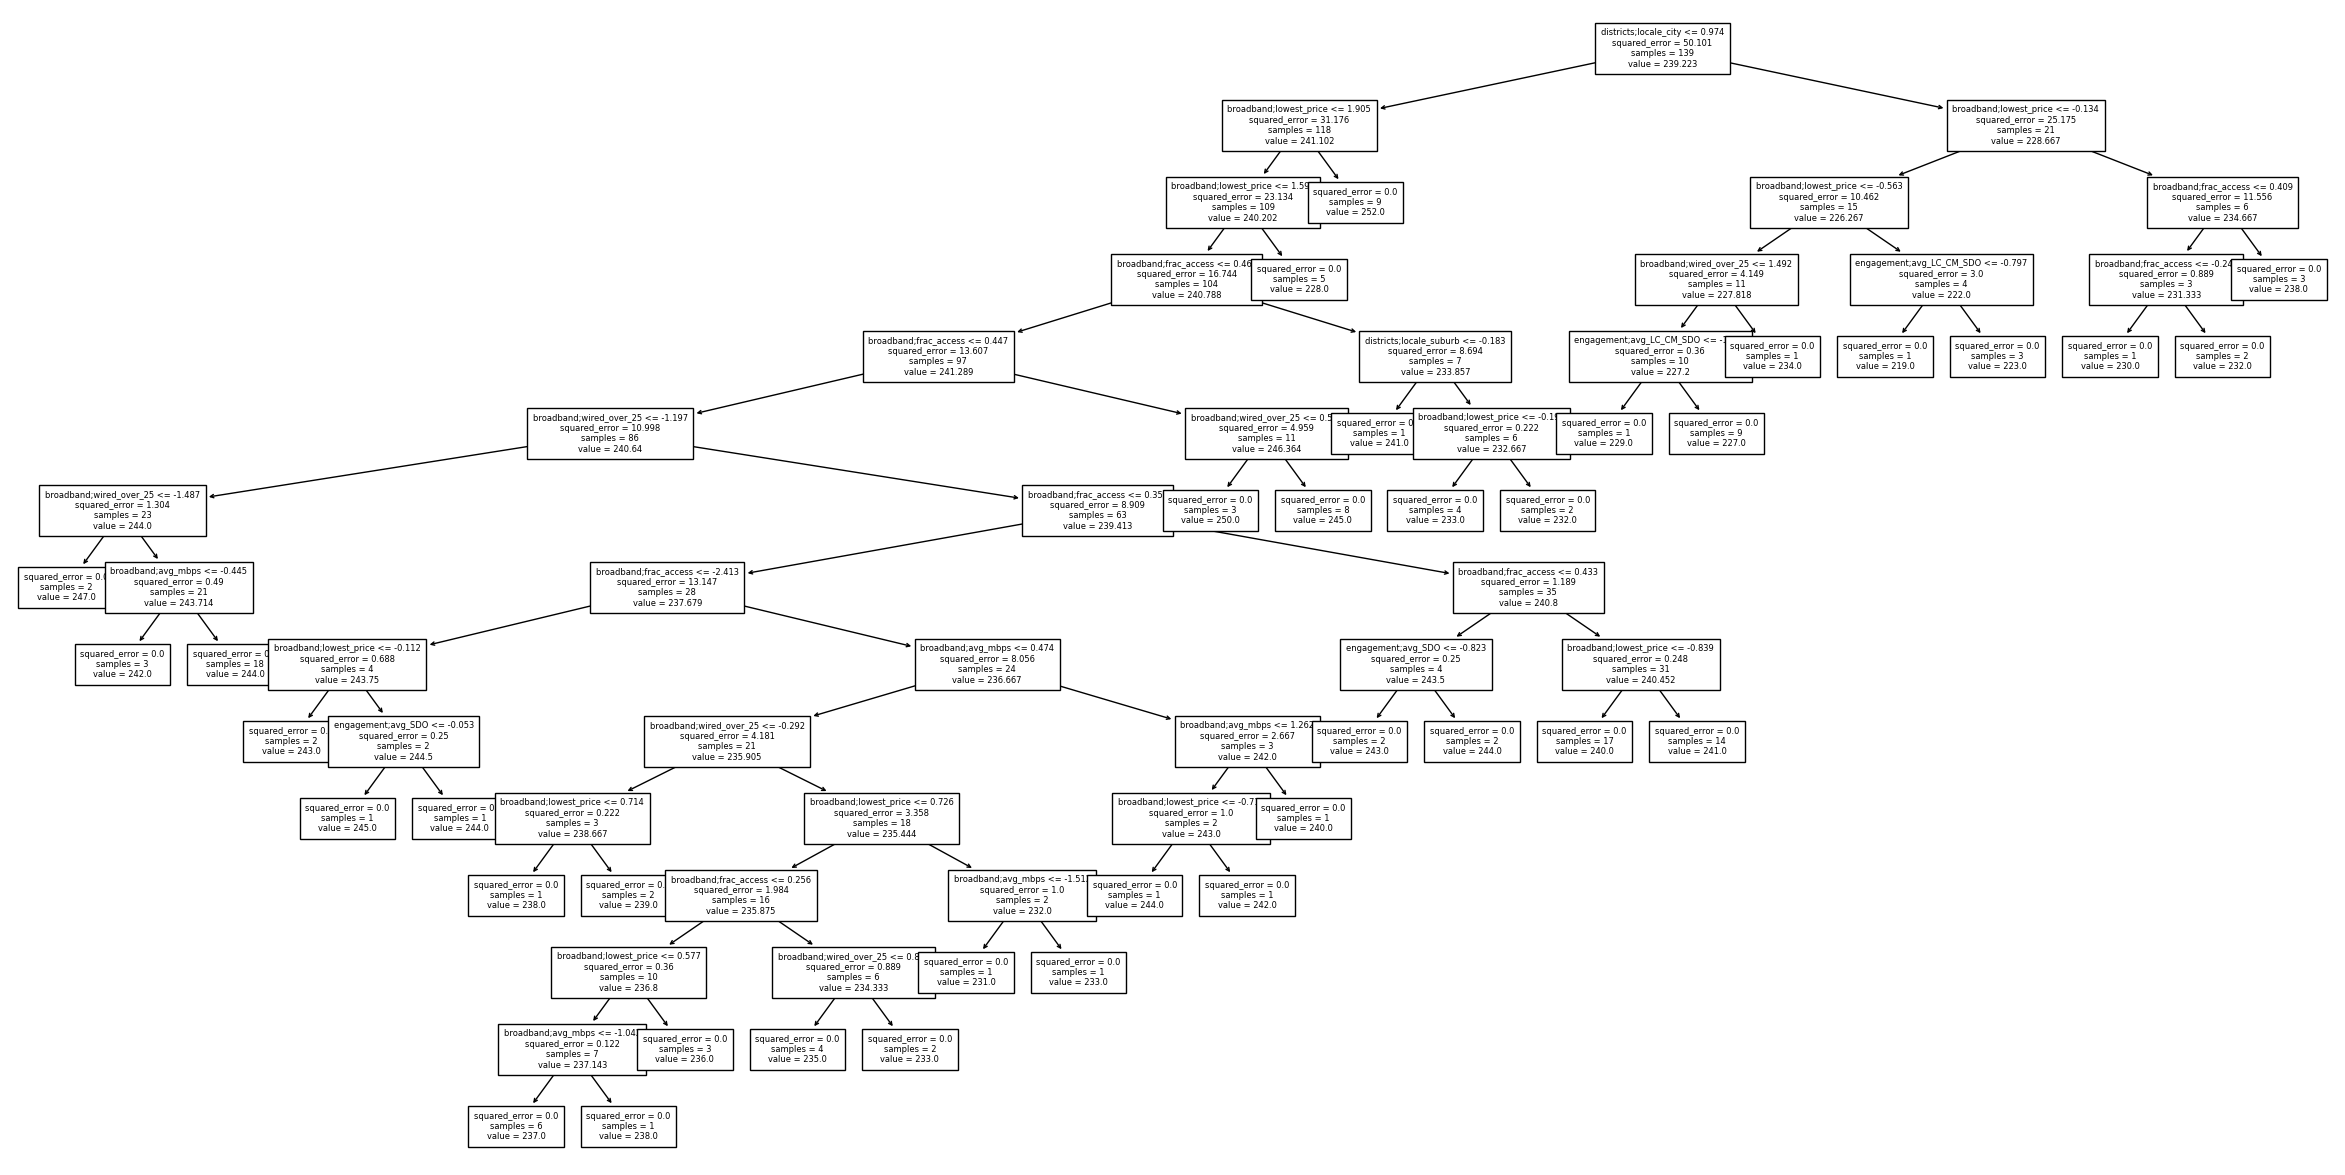

In [298]:
fig, ax = plt.subplots(figsize=(30,15))
plot_tree(five_fold_results[0][0]['estimator'][0]['decisiontreeregressor'], 
          feature_names=['engagement;avg_SDO',
                         'engagement;avg_CM',
                         'engagement;avg_LC', 
                         'engagement;avg_LC_CM_SDO', 
                         'engagement;avg_Missing',
                         'districts;locale_city', 
                         'districts;locale_suburb', 
                         'districts;locale_town',
                         'districts;locale_rural',
                         'broadband;wired_over_25',
                         'broadband;avg_mbps', 
                         'broadband;frac_access', 
                         'broadband;lowest_price'],
          filled=False,
          fontsize=6,
          ax=ax);

-----------